# ES335 Assignment 1: Task 1

## Imports

In [68]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import random
import seaborn as sns

## Utility functions

In [69]:
activity_classes = ["LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]

def get_sample_data(path, files_per_activity=-1):
    sample_data = []
    for activity_class in activity_classes:
        subpath = os.path.join(path, activity_class)
        files = os.listdir(subpath)
        num_files = len(files) if files_per_activity == -1 else files_per_activity
        for file in range(num_files):
            sample_data.append(os.path.join(subpath, files[file]))
    return sample_data

def load_csv_files(directory, label, add_timestamp=True, add_total_acc=True, trim_data=True):
    df_list = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            df['subject'] = filename.replace('.csv', '')
            # 50 samples per second
            # 1 sample takes 1/50 seconds
            if add_timestamp:
                df['timestamp'] = (df.index + 1) / 50
            if add_total_acc:
                df['total_acc'] = df['accx'] ** 2 + df['accy'] ** 2 + df['accz'] ** 2
            if trim_data:
                df_list.append(df.iloc[100:600, :])
            else:
                df_list.append(df)
    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df['y'] = label
    return combined_df

def prepare_dataset(path):
    train_path = os.path.join(path, "Train")
    test_path = os.path.join(path, "Test")
    
    train_dfs = pd.concat([load_csv_files(os.path.join(train_path, activity_class), label) for label, activity_class in enumerate(activity_classes)])
    test_dfs = pd.concat([load_csv_files(os.path.join(test_path, activity_class), label) for label, activity_class in enumerate(activity_classes)])
    
    return train_dfs, test_dfs

def get_tsfel_features(tsfel_features_path):   
    data = pd.DataFrame()
    for label, activity_class in enumerate(activity_classes):
        folder_path = os.path.join(tsfel_features_path, activity_class)
        # files = os.listdir(folder_path)
        dfs = load_csv_files(folder_path, label, False, False, False)
        data = pd.concat([data, dfs], axis=0, ignore_index=True)
    return data

def plot_pca(x: np.ndarray, y: np.ndarray, components=2, dot_size=0.5):
    scaler = StandardScaler()
    x_normalized = scaler.fit_transform(x)
    pca = PCA(n_components=components)
    x_pca = pca.fit_transform(x_normalized)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap='viridis', s=dot_size)
    plt.gca().add_artist(plt.legend(*scatter.legend_elements(), loc="upper right", title="Labels"))
    plt.xlabel(f'First Principal Component')
    plt.ylabel(f'Second Principal Component')
    plt.title('PCA Scatter Plot')
    plt.show()

## Solutions

### 1. Plot the waveform for one sample data from each activity class. Are you able to see any difference/similarities between the activities? You can plot a subplot having 6 columns to show differences/similarities between the activities. Do you think the model will be able to classify the activities based on the data? [0.5 marks]

In [70]:
sample_data = get_sample_data(os.path.join("Datasets", 'Combined', 'Train'), 1)

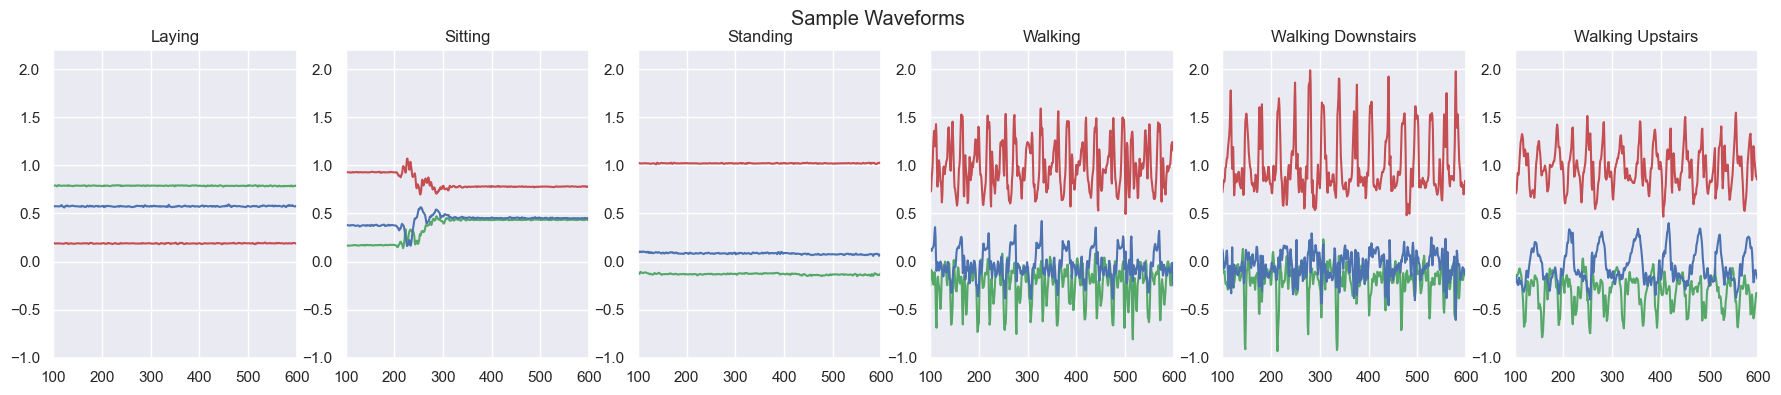

In [71]:
titles = [sample.split('\\')[3].title().replace('_', ' ') for sample in sample_data]

def plot_waveforms():
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(22, 4))
    fig.suptitle('Sample Waveforms')

    dfs = [pd.read_csv(sample_data[i]).iloc[100:600, :] for i in range(6)]

    for i, ax in enumerate((ax1, ax2, ax3, ax4, ax5, ax6)):
        ax.set_title(titles[i])
        ax.set_ylim([-1, 2.2])
        ax.set_xlim([100, 600])
        ax.plot(dfs[i]['accx'], color='r')
        ax.plot(dfs[i]['accy'], color='g')
        ax.plot(dfs[i]['accz'], color='b')

plot_waveforms()

Yes, the model will be able to classify the activities based on the data. 

### 2. Do you think we need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities(walking, walking_downstairs, walking_upstairs)? Look at the linear acceleration $(acc_x^2 + acc_y^2 + acc_z^2)$ for each activity and justify your answer.


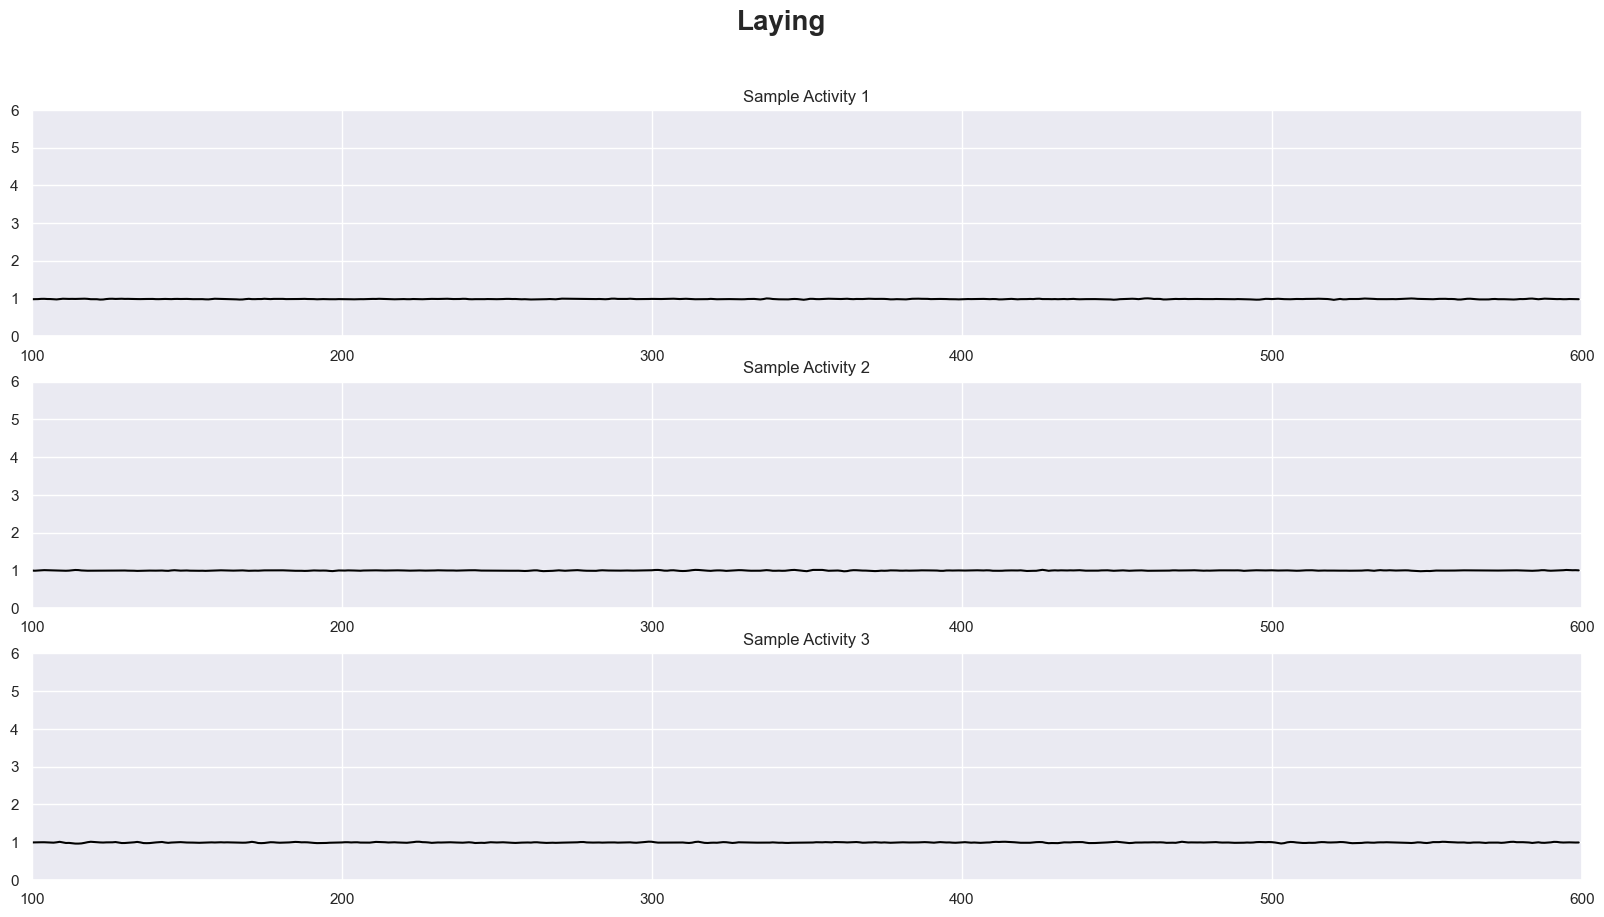

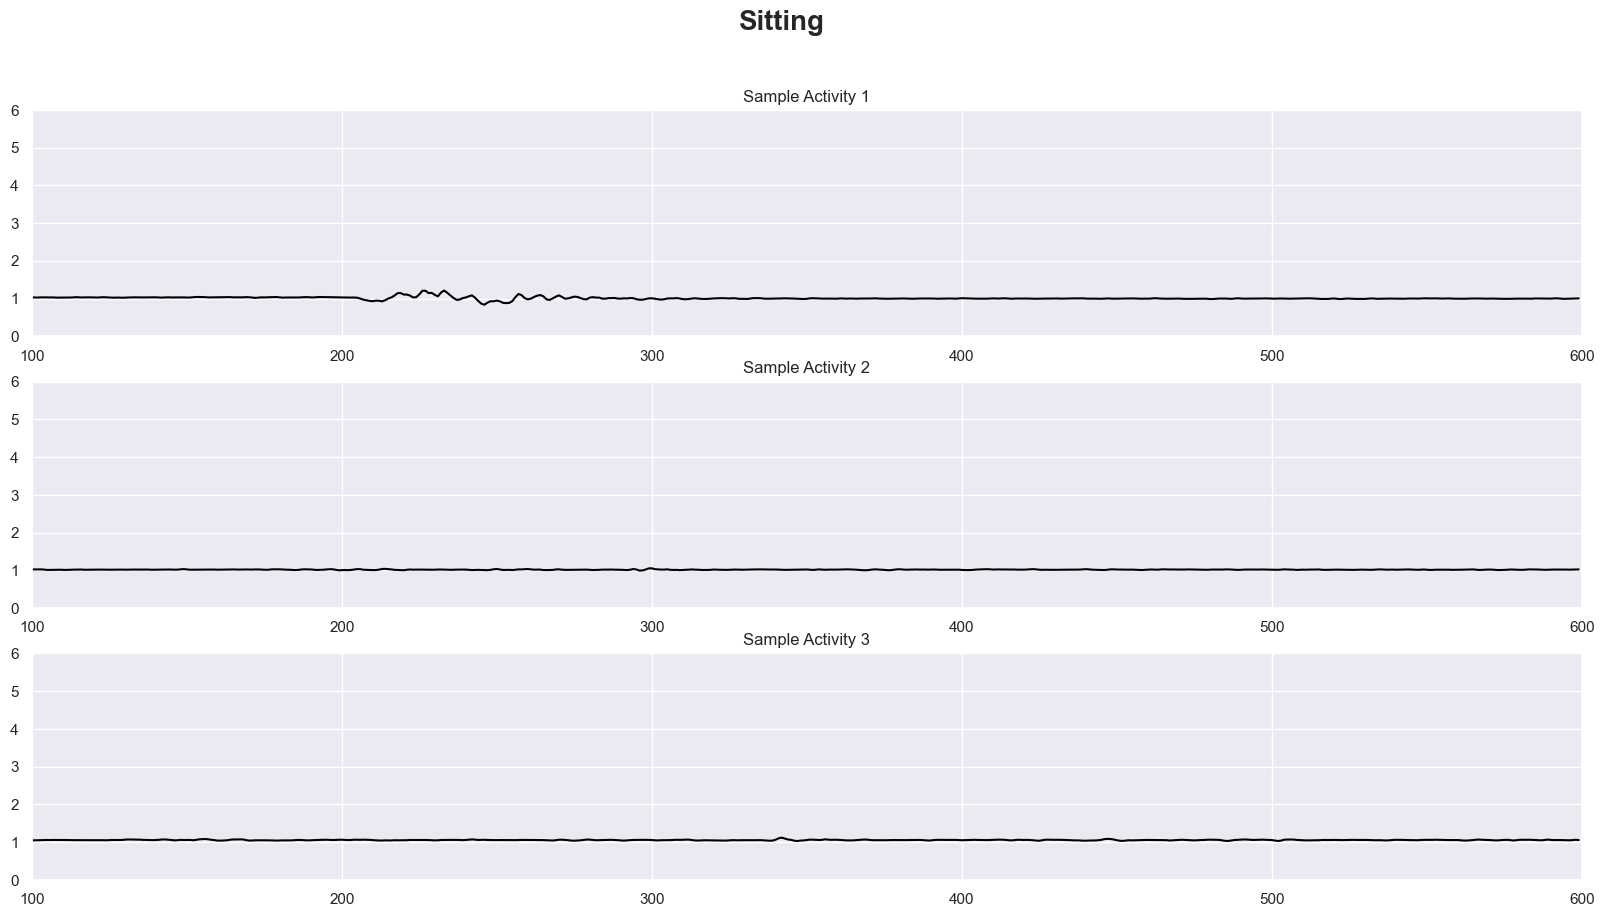

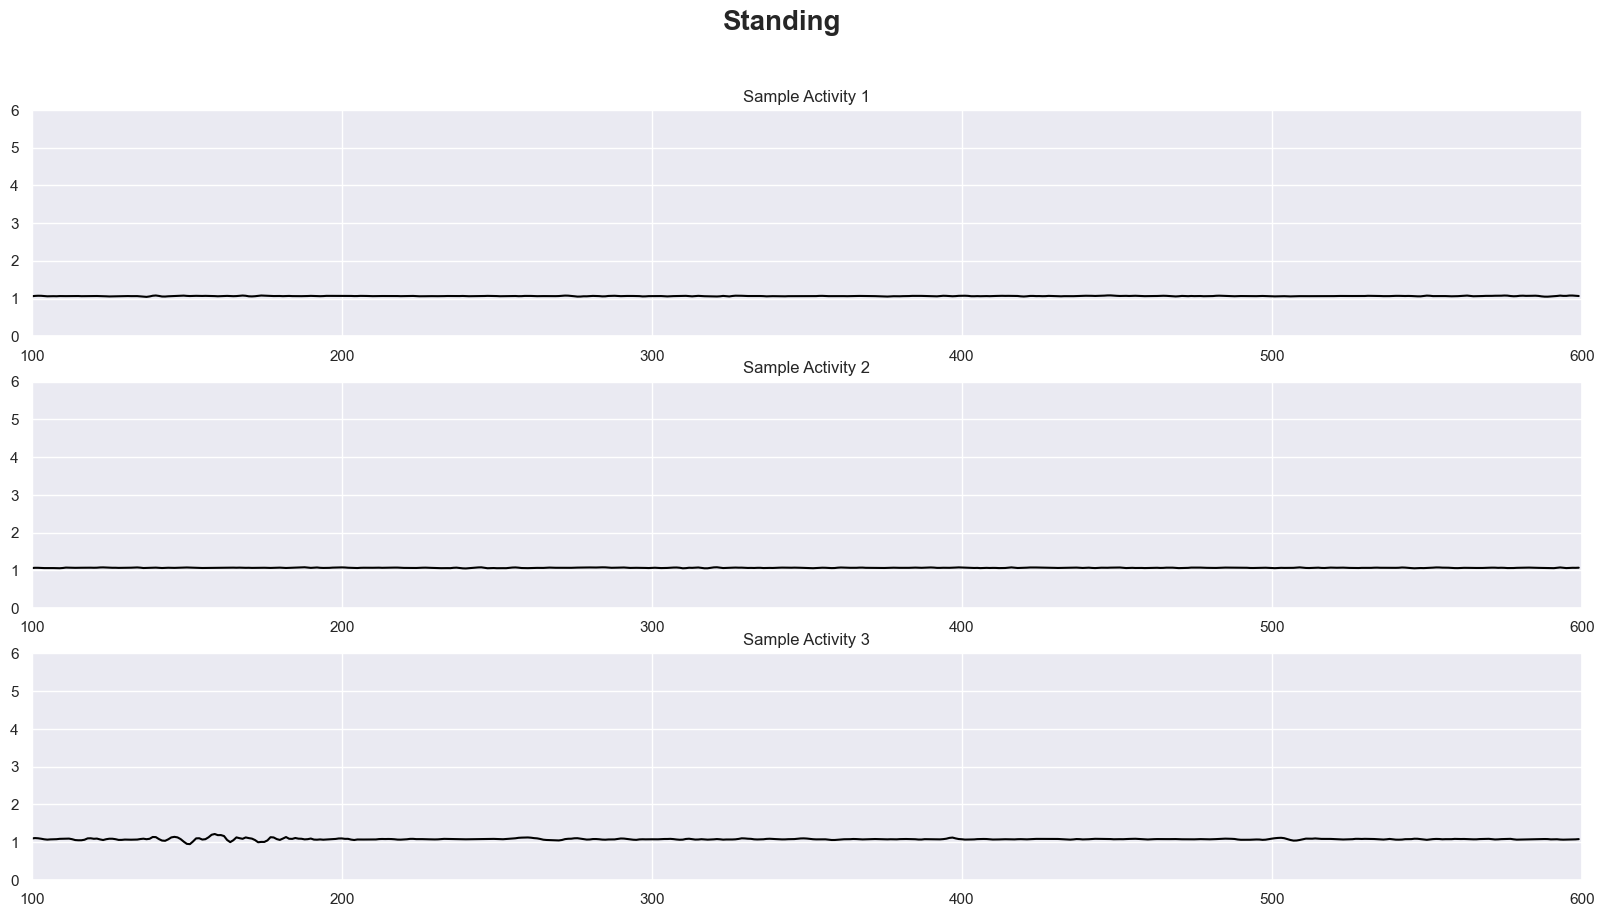

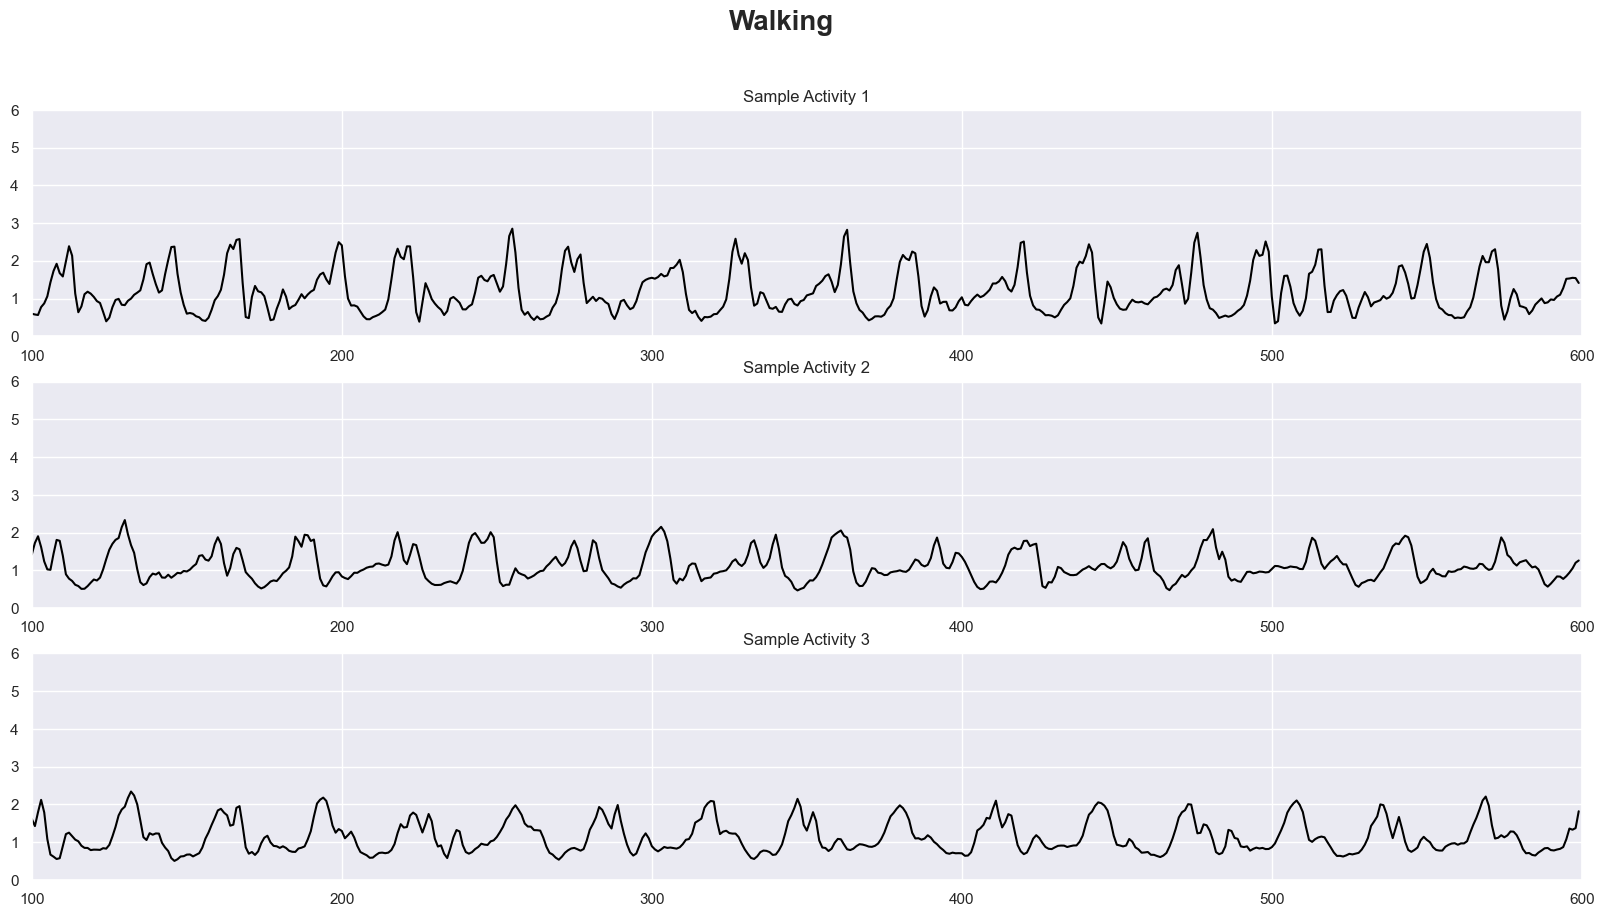

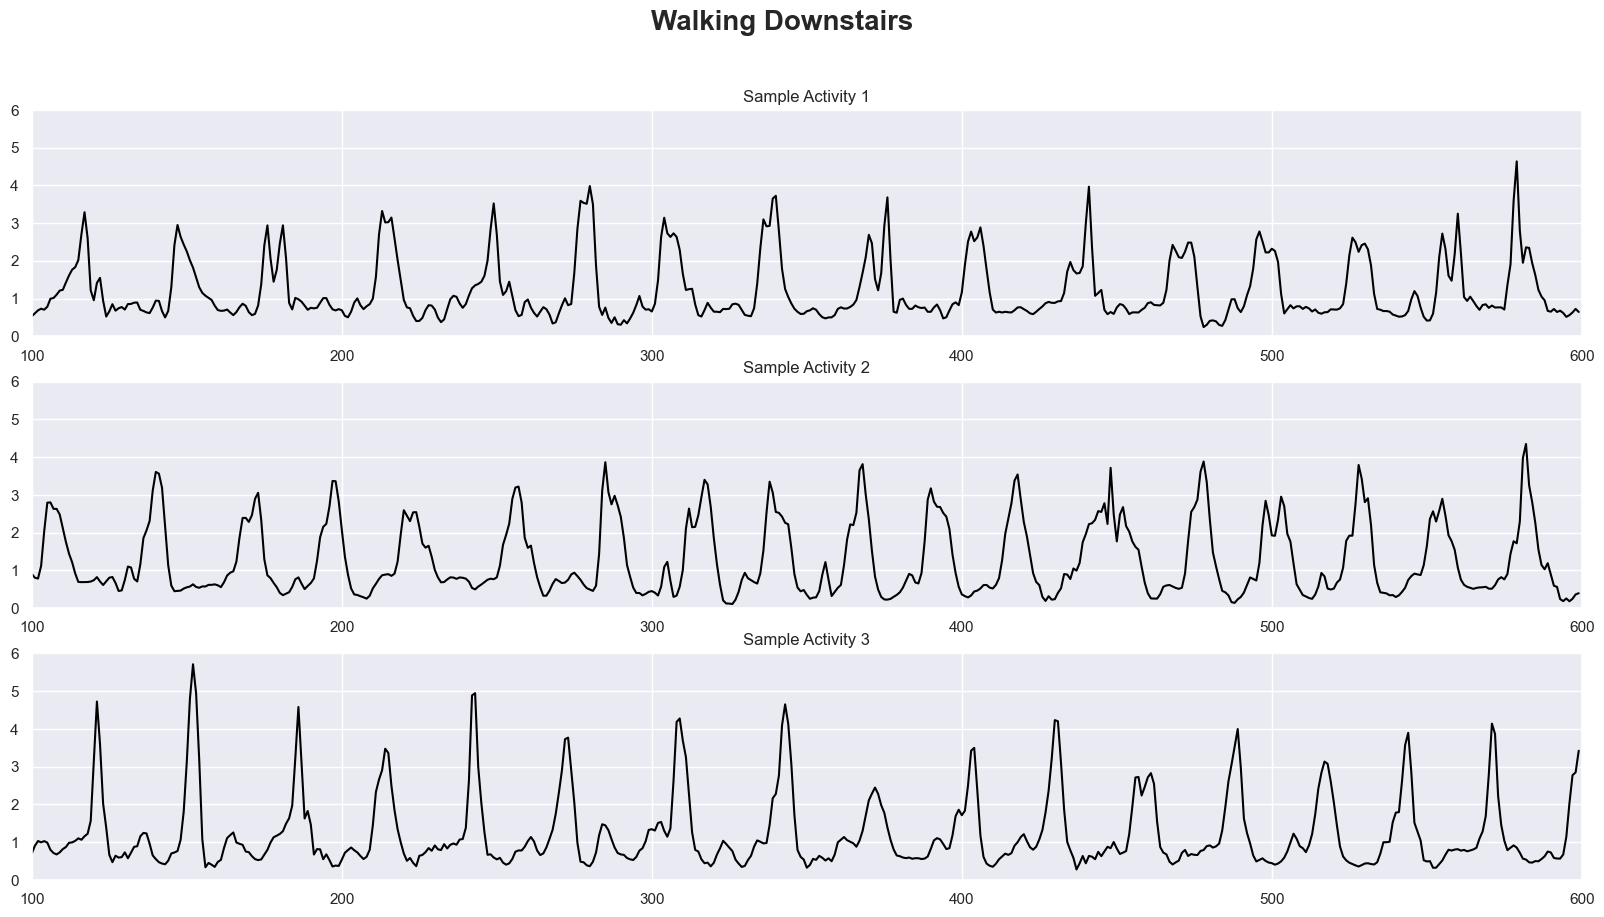

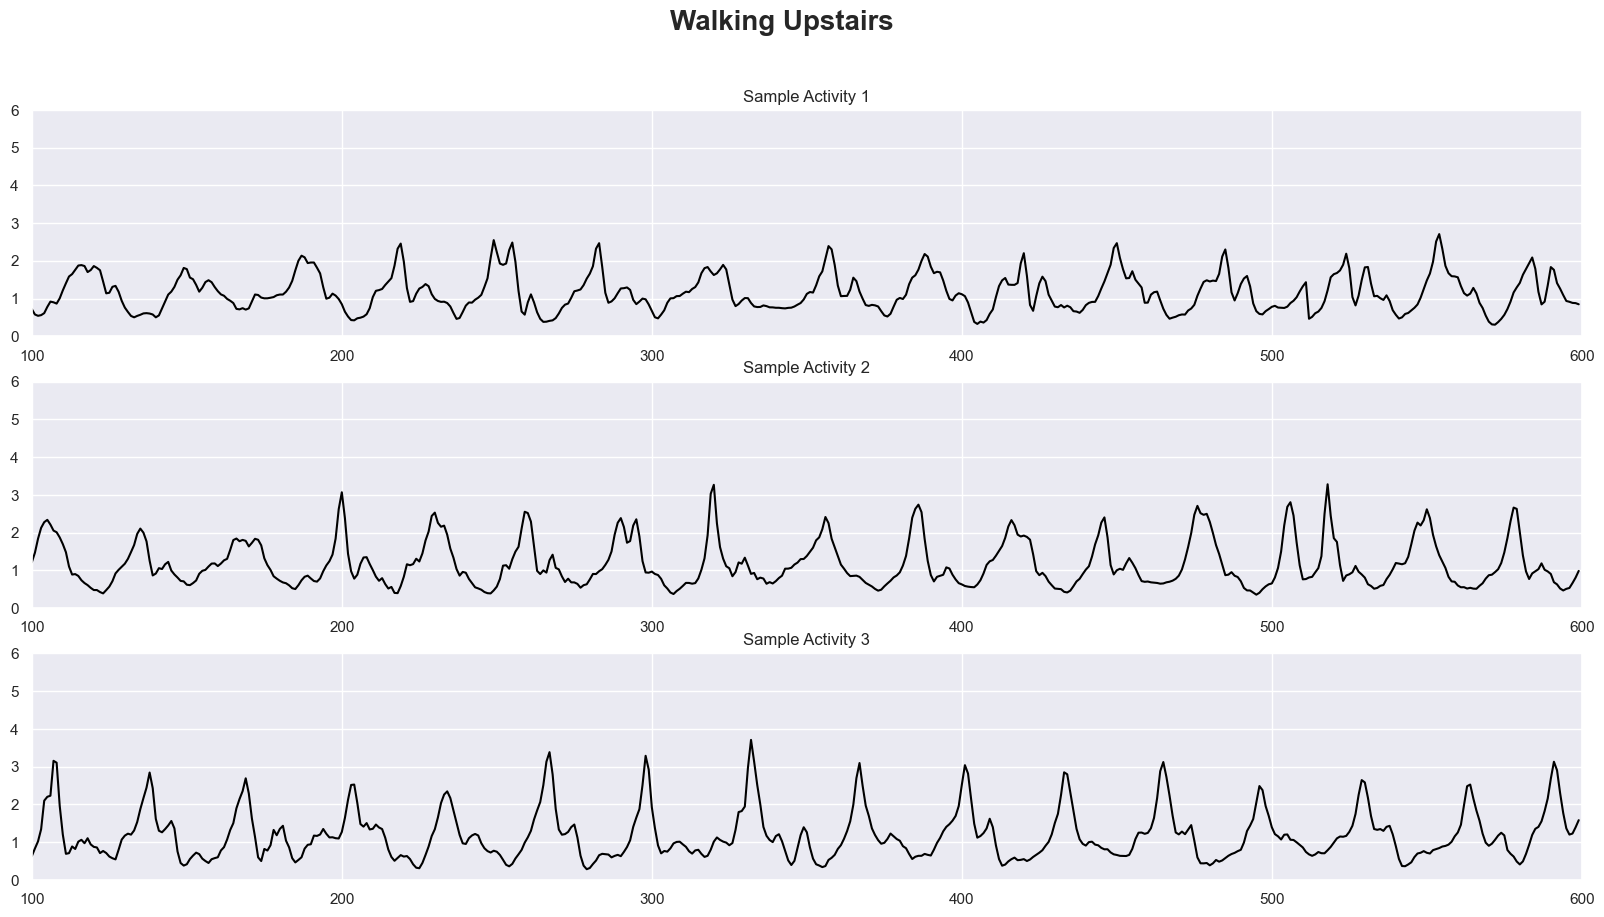

In [72]:
def plot_sample_activities():
    activity_sample_data = get_sample_data(os.path.join("Datasets", 'Combined', 'Train'), 3)

    dfs = [pd.read_csv(activity_sample_data[i]).iloc[100:600, :] for i in range(18)]

    linear_accelerations = [dfs[i]['accx'] * dfs[i]['accx'] + dfs[i]['accy'] * dfs[i]['accy'] + dfs[i]['accz'] * dfs[i]['accz'] for i in range(18)]

    fig, ax = [], []
    for i in range(6):
        fig_, ax_ = plt.subplots(3, 1, figsize=(20, 10))
        fig.append(fig_)
        ax.append(ax_)

    for i, (fig_, ax_) in enumerate(zip(fig, ax)):
        fig_.suptitle(titles[i], fontsize=20, fontweight='heavy')
        for j in range(3):
            ax_[j].set_title(f'Sample Activity {j + 1}')
            ax_[j].set_xlim([100, 600])
            ax_[j].set_ylim([0, 6])
            ax_[j].plot(linear_accelerations[3 * i + j], color='black')

plot_sample_activities()

For classifying static activities, machine learning models might be unnecessary because linear acceleration plots can often be visually inspected to distinguish between different activities. However, for dynamic activities such as walking, a machine learning model is more appropriate. This is because dynamic activities do not have straightforward visual cues that clearly reveal the activity being performed, making it difficult to classify based on visual inspection alone.

### 3. Visualize the data using PCA.

In [73]:
train, test = prepare_dataset("Datasets/Combined")

#### Use PCA (Principal Component Analysis) on Total Acceleration $(acc_x^2+acc_y^2+acc_z^2)$ to compress the acceleration timeseries into two features and plot a scatter plot to visualize different class of activities. 


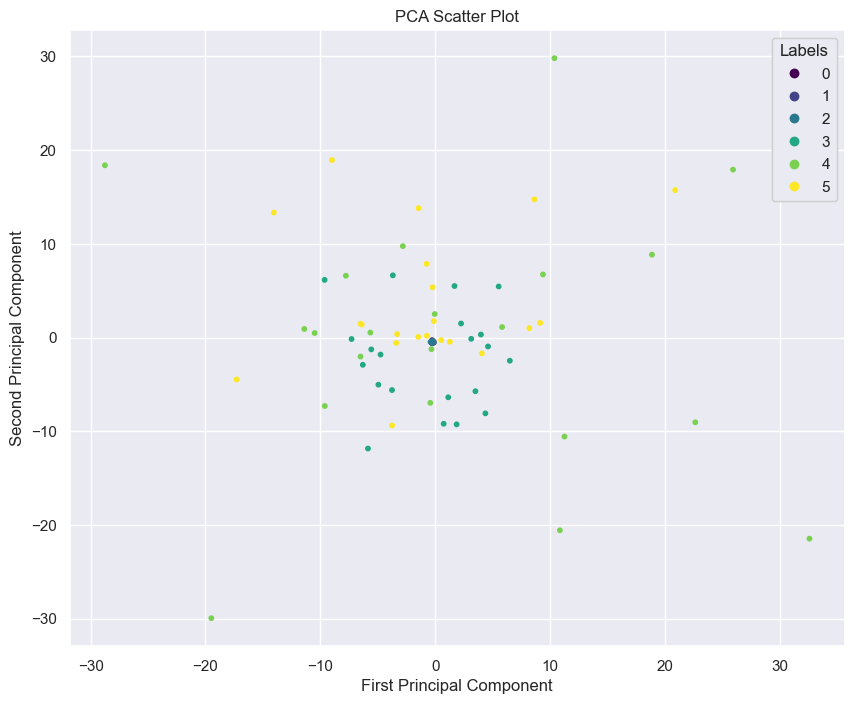

In [74]:
def plot_pca_total_acceleration_timeseries(dataset):
    data = dataset[['total_acc', 'y']].to_numpy().reshape(-1, 500, 2)
    x = data[:, :, 0]
    y = data[:, :, 1]
    y = y[:, 0]
    plot_pca(x, y, dot_size=10)
    
plot_pca_total_acceleration_timeseries(train)

#### Next, use TSFEL (a featurizer library) to create features (your choice which ones you feel are useful) and then perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.

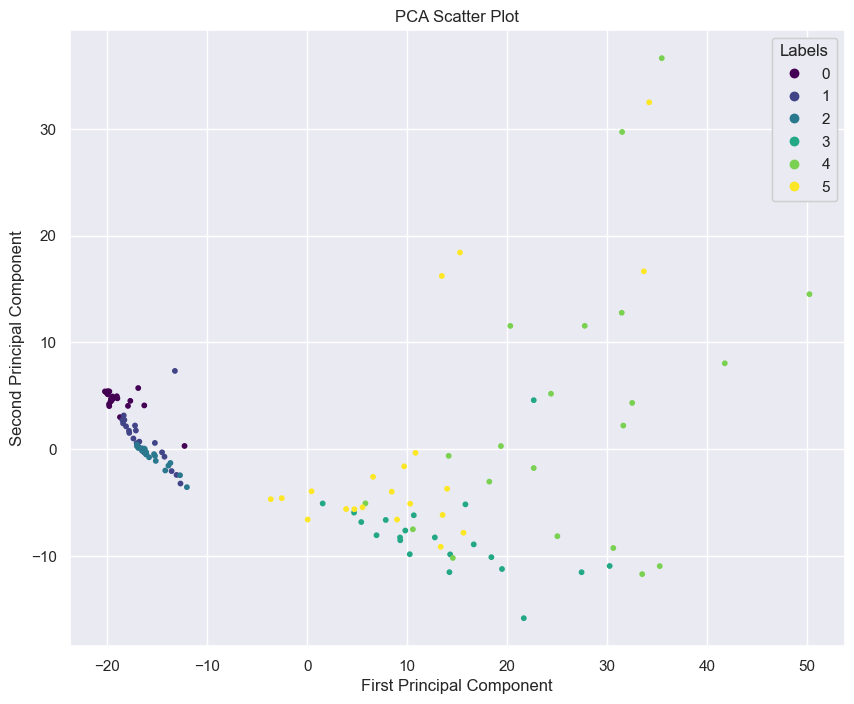

In [75]:
data = get_tsfel_features(r'Datasets/TSFEL_3axes_allfeatures/Train')

def plot_pca_tsfel(x: np.ndarray, y: np.ndarray, components=2):
    scaler = StandardScaler()
    x_normalized = scaler.fit_transform(x)
    pca = PCA(n_components=components)
    x_pca = pca.fit_transform(x_normalized)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap='viridis', s=10)
    plt.gca().add_artist(plt.legend(*scatter.legend_elements(), loc="upper right", title="Labels"))
    plt.xlabel(f'First Principal Component')
    plt.ylabel(f'Second Principal Component')
    plt.title('PCA Scatter Plot')
    plt.show()

    components_df = pd.DataFrame(pca.components_, columns=data.columns[:-2], index=[f'PC{i+1}' for i in range(components)])
    return components_df.T

def plot_pca_acceleration_tsfel(data: pd.DataFrame):
    x = data[data.columns[:-2]].to_numpy()
    y = data['y'].to_numpy()
    return plot_pca_tsfel(x, y, 2)

loadings = plot_pca_acceleration_tsfel(data)
PC1, PC2 = loadings['PC1'], loadings['PC2']
PC1 = PC1.sort_values()
PC2 = PC2.sort_values()

In [76]:

def get_correlation_data():
    x = data[data.columns[:-2]]

    redundant_features = []
    zero_std_dev = 0

    for feature in x.columns:
        if len(x[feature].unique()) == 1:
            redundant_features.append(feature)
            zero_std_dev += 1

    x = x.drop(columns=redundant_features)
    corr = x.corr()
    features = len(x.columns)
    correlations = []
    for i in range(features):
        for j in range(i + 1, features):
            feature1 = x.columns[i]
            feature2 = x.columns[j]
            correlation = corr.iloc[i, j]
            if np.abs(correlation) >= 0: # removes nan
                correlations.append([correlation, [feature1, feature2]])

    correlations.sort(reverse=True)
    print(f'There are {zero_std_dev} columns with zero standard deviation')
    
    return correlations, corr

correlations, corr_mat = get_correlation_data()
print(*(correlations[:40] + correlations[::-1][:40][::-1]), sep='\n')
display(corr_mat) # NaN comes due to division by 0 (for constant features std dev is 0), this means these features are redundant

There are 39 columns with zero standard deviation
[np.float64(1.0000000000000007), ['accx_Spectral centroid', 'accx_Spectral slope']]
[np.float64(1.0000000000000004), ['accz_Mean absolute diff', 'accz_Sum absolute diff']]
[np.float64(1.0000000000000004), ['accy_Spectral centroid', 'accy_Spectral slope']]
[np.float64(1.0000000000000004), ['accy_Absolute energy', 'accy_Average power']]
[np.float64(1.0000000000000002), ['accz_LPCC_3', 'accz_LPCC_9']]
[np.float64(1.0000000000000002), ['accz_LPCC_10', 'accz_LPCC_2']]
[np.float64(1.0000000000000002), ['accz_LPCC_1', 'accz_LPCC_11']]
[np.float64(1.0000000000000002), ['accx_Mean absolute diff', 'accx_Sum absolute diff']]
[np.float64(1.0000000000000002), ['accx_LPCC_5', 'accx_LPCC_7']]
[np.float64(1.0000000000000002), ['accx_LPCC_1', 'accx_LPCC_11']]
[np.float64(1.0), ['accz_Maximum frequency', 'accz_Spectral roll-off']]
[np.float64(1.0), ['accz_LPCC_5', 'accz_LPCC_7']]
[np.float64(1.0), ['accz_LPCC_4', 'accz_LPCC_8']]
[np.float64(1.0), ['accy_

,accx_Absolute energy,accx_Area under the curve,accx_Autocorrelation,accx_Average power,accx_Centroid,accx_Detrended fluctuation analysis,accx_ECDF Percentile_0,accx_ECDF Percentile_1,accx_Entropy,accx_FFT mean coefficient_0,...,accz_Wavelet variance_0,accz_Wavelet variance_1,accz_Wavelet variance_2,accz_Wavelet variance_3,accz_Wavelet variance_4,accz_Wavelet variance_5,accz_Wavelet variance_6,accz_Wavelet variance_7,accz_Wavelet variance_8,accz_Zero crossing rate
accx_Absolute energy,1.000000,0.980108,-0.269922,1.000000,0.257370,0.282594,0.853889,0.973178,-0.170872,0.160930,...,0.347847,0.340040,0.319131,0.283443,0.257058,0.239035,0.224354,0.207789,0.185356,0.485104
accx_Area under the curve,0.980108,1.000000,-0.226415,0.980108,0.273590,0.209675,0.919913,0.951653,-0.200356,0.143046,...,0.275708,0.275669,0.262925,0.240521,0.224686,0.213264,0.202367,0.187669,0.165790,0.380451
accx_Autocorrelation,-0.269922,-0.226415,1.000000,-0.269922,-0.465086,0.023634,-0.238159,-0.258918,0.111182,0.214079,...,-0.186623,-0.188069,-0.191025,-0.184937,-0.178926,-0.174079,-0.170220,-0.165156,-0.155888,-0.206092
accx_Average power,1.000000,0.980108,-0.269922,1.000000,0.257370,0.282594,0.853889,0.973178,-0.170872,0.160930,...,0.347847,0.340040,0.319131,0.283443,0.257058,0.239035,0.224354,0.207789,0.185356,0.485104
accx_Centroid,0.257370,0.273590,-0.465086,0.257370,1.000000,0.011586,0.311401,0.262041,-0.052466,-0.057700,...,0.088871,0.091502,0.096845,0.096352,0.093626,0.091459,0.090414,0.089126,0.085766,0.090010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
accz_Wavelet variance_5,0.239035,0.213264,-0.174079,0.239035,0.091459,0.489509,0.017855,0.340792,0.321793,0.152072,...,0.591988,0.692566,0.854244,0.954397,0.992660,1.000000,0.993820,0.967896,0.907001,0.171006
accz_Wavelet variance_6,0.224354,0.202367,-0.170220,0.224354,0.090414,0.492040,0.012141,0.325955,0.324998,0.162608,...,0.547844,0.651645,0.817346,0.926585,0.975648,0.993820,1.000000,0.989247,0.945597,0.150391
accz_Wavelet variance_7,0.207789,0.187669,-0.165156,0.207789,0.089126,0.495602,0.000787,0.308488,0.331928,0.180267,...,0.497965,0.603857,0.772560,0.884810,0.939895,0.967896,0.989247,1.000000,0.982752,0.141357
accz_Wavelet variance_8,0.185356,0.165790,-0.155888,0.185356,0.085766,0.491873,-0.016444,0.283191,0.336631,0.200270,...,0.430505,0.533120,0.700712,0.811054,0.869394,0.907001,0.945597,0.982752,1.000000,0.141796


#### Now use the features provided by the dataset and perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.

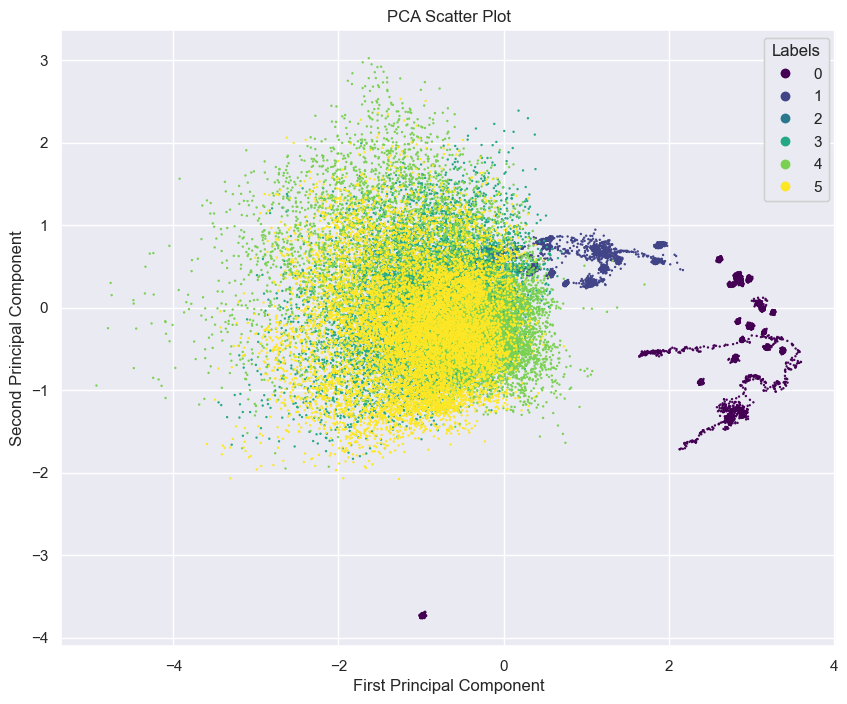

In [77]:
def plot_pca_acceleration(data: pd.DataFrame):
    x = data[['accx', 'accy', 'accz']].to_numpy()
    y = data['y'].to_numpy()
    plot_pca(x, y, 2)

plot_pca_acceleration(train)

### 4. Calculate the correlation matrix of the features obtained by TSFEL and provided in the dataset. Identify the features that are highly correlated with each other. Are there any redundant features? [1 marks]

There are 39 columns with zero standard deviation
Features remaining after removing the highly correlated and the ones with 0 standard deviation: 26


<Axes: >

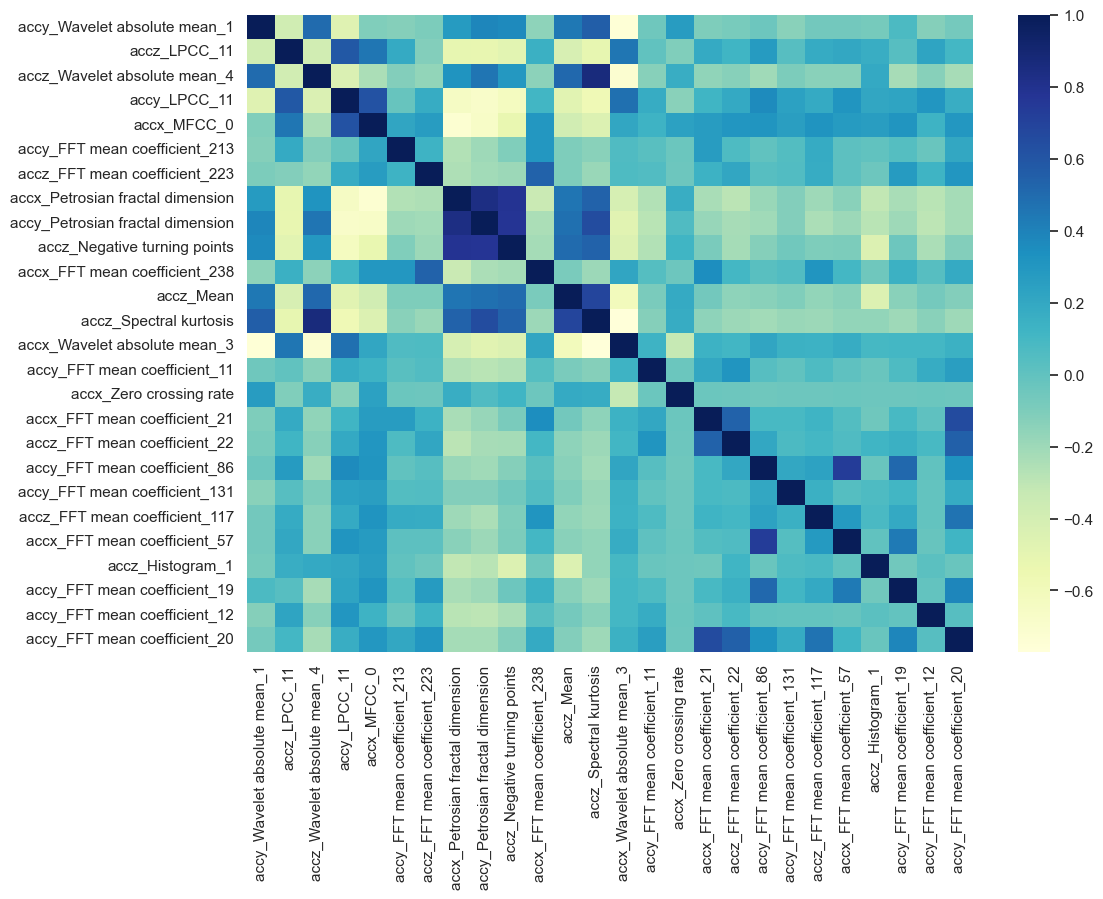

In [78]:
def cluster_correlated_data(eps=0.1):
    correlated_clusters = {}
    correlations, _ = get_correlation_data()
    cluster_id = {}
    next_id = 0
    
    for feature_pair in correlations:
        corr, features = feature_pair
        
        if np.abs(corr) >= 1 - eps:
            if features[0] in cluster_id and features[1] in cluster_id:
                id1 = cluster_id[features[0]]
                id2 = cluster_id[features[1]]
                
                if id1 != id2:
                    # merge both the clusters
                    for f in correlated_clusters[id2]:
                        cluster_id[f] = id1
                        correlated_clusters[id1].append(f)
                        
                    del correlated_clusters[id2]
            elif features[0] in cluster_id:
                correlated_clusters[cluster_id[features[0]]].append(features[1])
                cluster_id[features[1]] = cluster_id[features[0]]
            elif features[1] in cluster_id:
                correlated_clusters[cluster_id[features[1]]].append(features[0])
                cluster_id[features[0]] = cluster_id[features[1]]
            else:
                correlated_clusters[next_id] = features
                cluster_id[features[0]] = cluster_id[features[1]] = next_id
                next_id += 1
                
    print("Features remaining after removing the highly correlated and the ones with 0 standard deviation:", len(correlated_clusters))
    
    feature_list = [random.choice(correlated_clusters[idx]) for idx in correlated_clusters.keys()]
    return feature_list

useful_features = cluster_correlated_data(0.1)

seaborn_corr = data[useful_features].corr()
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(seaborn_corr, cmap="YlGnBu") 

There are 39 columns with zero standard deviation
Features remaining after removing the highly correlated and the ones with 0 standard deviation: 26


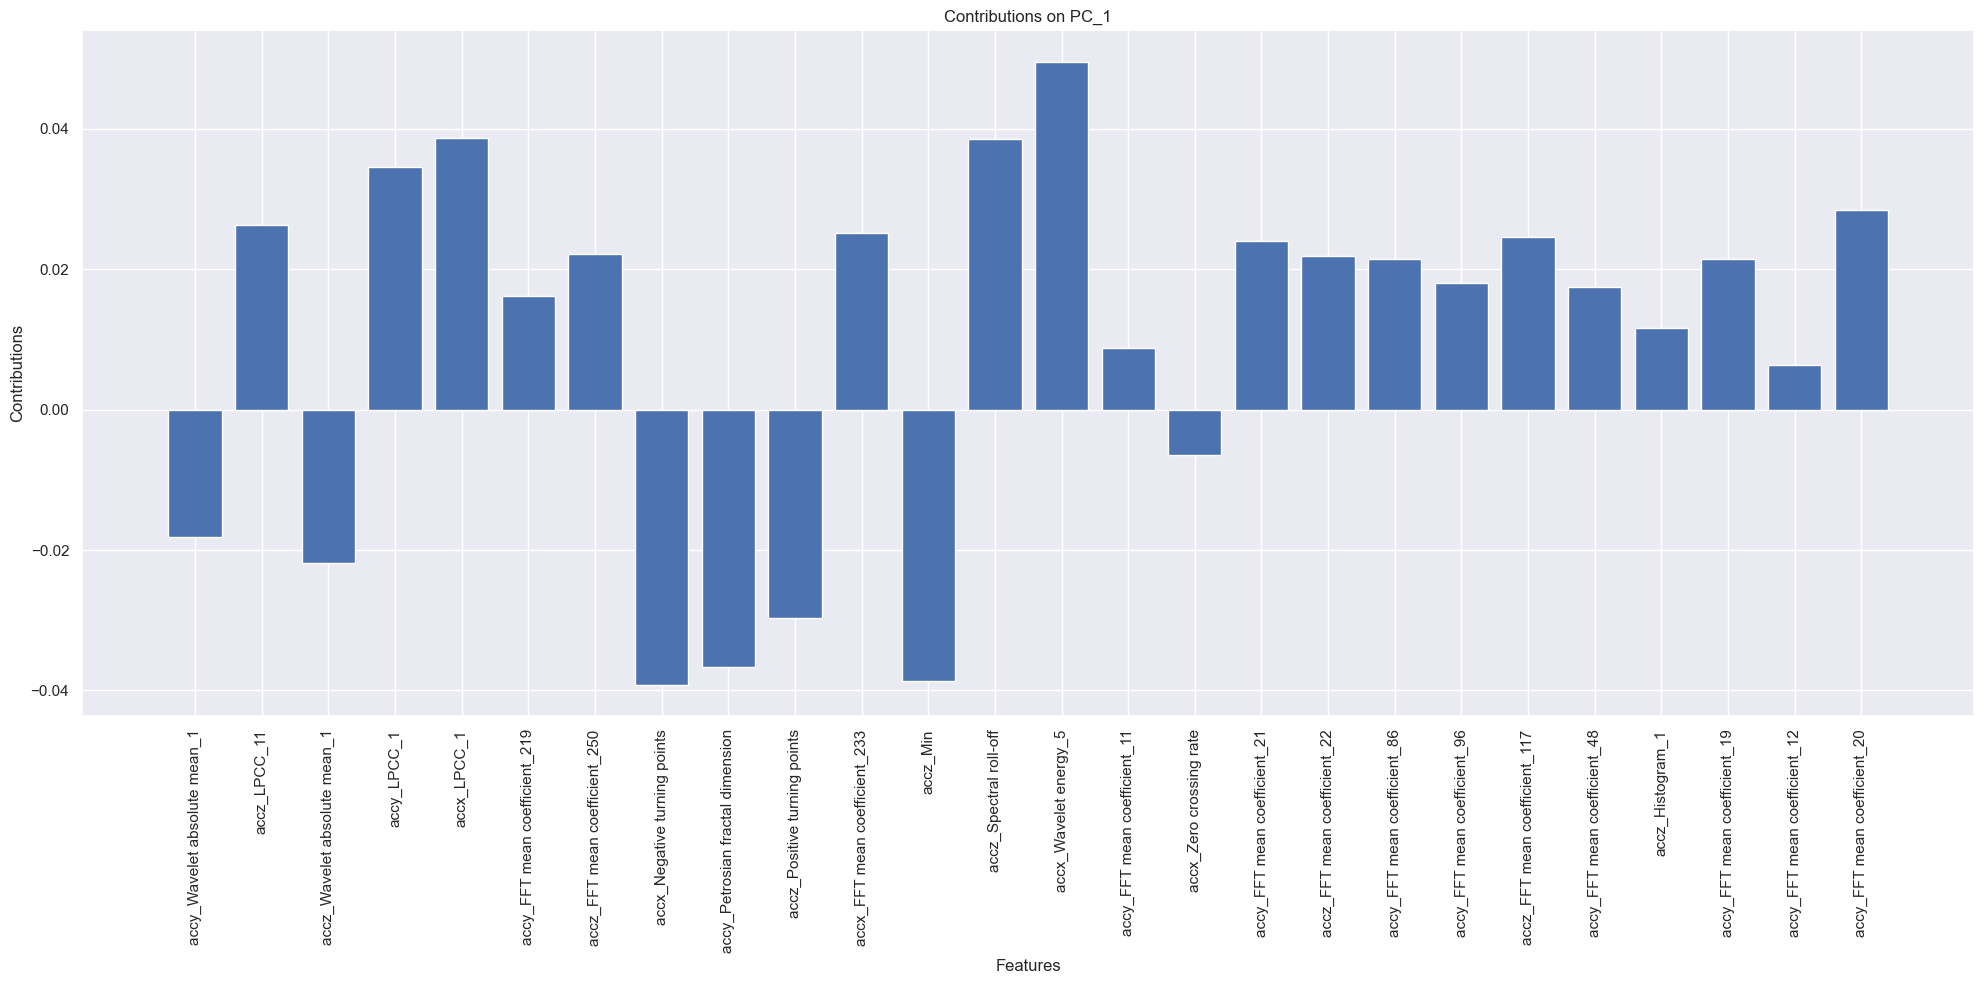

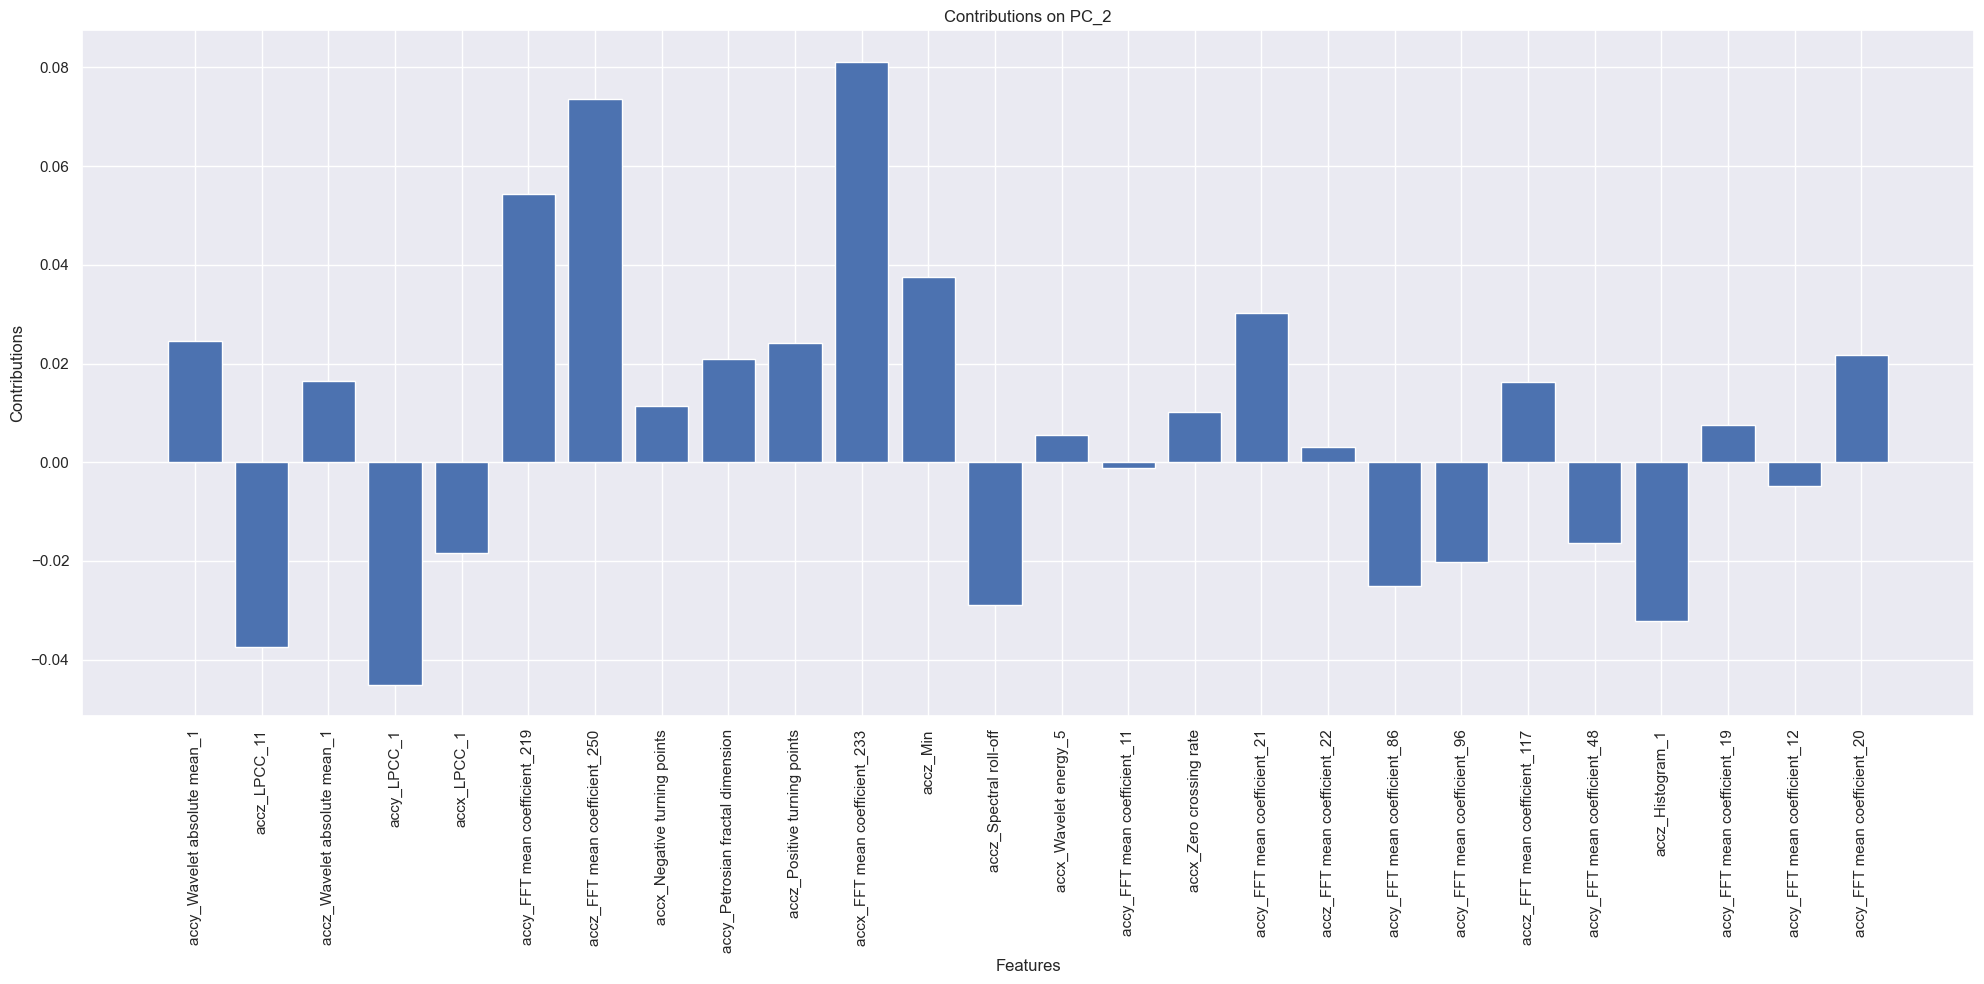

In [80]:
def plot_series_bar(series: pd.DataFrame, title='', xlabel='Features', ylabel='Contributions'):
    plt.figure(figsize=(20, 10))
    plt.bar(series.index, series)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90, ha='center')
    plt.tight_layout()
    plt.show()
    
def plot_feature_contributions():
    useful_features = cluster_correlated_data()
    plot_series_bar(PC1[useful_features], 'Contributions on PC_1')
    plot_series_bar(PC2[useful_features], 'Contributions on PC_2')

plot_feature_contributions()

#### Saving the useful features

In [88]:
def save_tsfel_features(data, features, filename):
    for i, activity in enumerate(activity_classes):
        for name, group in data.loc[data['y'] == i, [*features, 'subject']].groupby('subject'):
            os.makedirs(os.path.join(filename, activity), exist_ok=True)
            group.to_csv(os.path.join(filename, activity, f"{name}.csv"))

save_tsfel_features(get_tsfel_features("Datasets/TSFEL_3axes_allfeatures/Train"), useful_features, "Datasets/TSFEL_3axes_filtered_features/Train")
save_tsfel_features(get_tsfel_features("Datasets/TSFEL_3axes_allfeatures/Test"), useful_features, "Datasets/TSFEL_3axes_filtered_features/Test")